# [V3] Couple Candlesticks - Strategy - Backtesting 

In [45]:
# Switch Deal

### Import Library

In [46]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [47]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [48]:
data = dataset.copy()

In [49]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [50]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [51]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short' and r['RSI'] < 65.5 and -7.5 < r['price_move']:
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long' and r['RSI'] > 29.5 and -1.5 < r['price_move'] < 6.5:
        signal = 'long'
    return signal

In [52]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['ADX'] = round(data['ADX'])
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['RSI'] = round(data['RSI'])
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data['Close_s1'] = data['Close'].shift(1)
    data['price_move'] = data.apply(lambda r: (r['Close'] - r['Close_s1']) - 0.5 * r['ATR_14'] , axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [65]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 7.5
    tp_step = 30
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 25:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [66]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [67]:
# prepared_data[(prepared_data.index > '2024-11-05 00:00:00') & (prepared_data.index < '2024-11-05 15:00:00')]

In [68]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-03 13:05:00
End                       2025-02-13 14:45:00
Duration                   1563 days 01:40:00
Exposure Time [%]                   36.016045
Equity Final [$]                   2539.86379
Equity Peak [$]                     2557.2484
Return [%]                          69.324253
Buy & Hold Return [%]                47.38292
Return (Ann.) [%]                   13.244736
Volatility (Ann.) [%]                7.328623
Sharpe Ratio                         1.807261
Sortino Ratio                        4.517453
Calmar Ratio                         3.082013
Max. Drawdown [%]                    -4.29743
Avg. Drawdown [%]                   -0.362059
Max. Drawdown Duration      205 days 00:00:00
Avg. Drawdown Duration        4 days 14:01:00
# Trades                                 1363
Win Rate [%]                        34.409391
Best Trade [%]                       3.441747
Worst Trade [%]                     -0.532985
Avg. Trade [%]                    

In [57]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,27,32,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
1,1,33,68,909.37273,913.5,4.12727,0.004539,2020-11-04 10:10:00,2020-11-04 14:30:00,None,0 days 04:20:00
2,1,161,170,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,0 days 00:45:00
3,1,193,214,919.17567,917.2,-1.97567,-0.002149,2020-11-09 10:45:00,2020-11-09 13:55:00,None,0 days 03:10:00
4,1,242,244,929.97891,928.1,-1.87891,-0.002020,2020-11-10 10:35:00,2020-11-10 10:45:00,None,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...
1366,1,54033,54040,1333.90005,1335.1,1.19995,0.000900,2025-02-05 13:55:00,2025-02-05 14:30:00,None,0 days 00:35:00
1367,1,54054,54057,1344.70329,1341.2,-3.50329,-0.002605,2025-02-06 10:00:00,2025-02-06 10:15:00,None,0 days 00:15:00
1368,-1,54192,54193,1332.00028,1330.0,2.00028,0.001502,2025-02-10 14:25:00,2025-02-10 14:30:00,None,0 days 00:05:00
1369,1,54232,54241,1332.79972,1329.6,-3.19972,-0.002401,2025-02-11 13:30:00,2025-02-11 14:15:00,None,0 days 00:45:00


In [58]:
trades = stats['_trades']

In [59]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

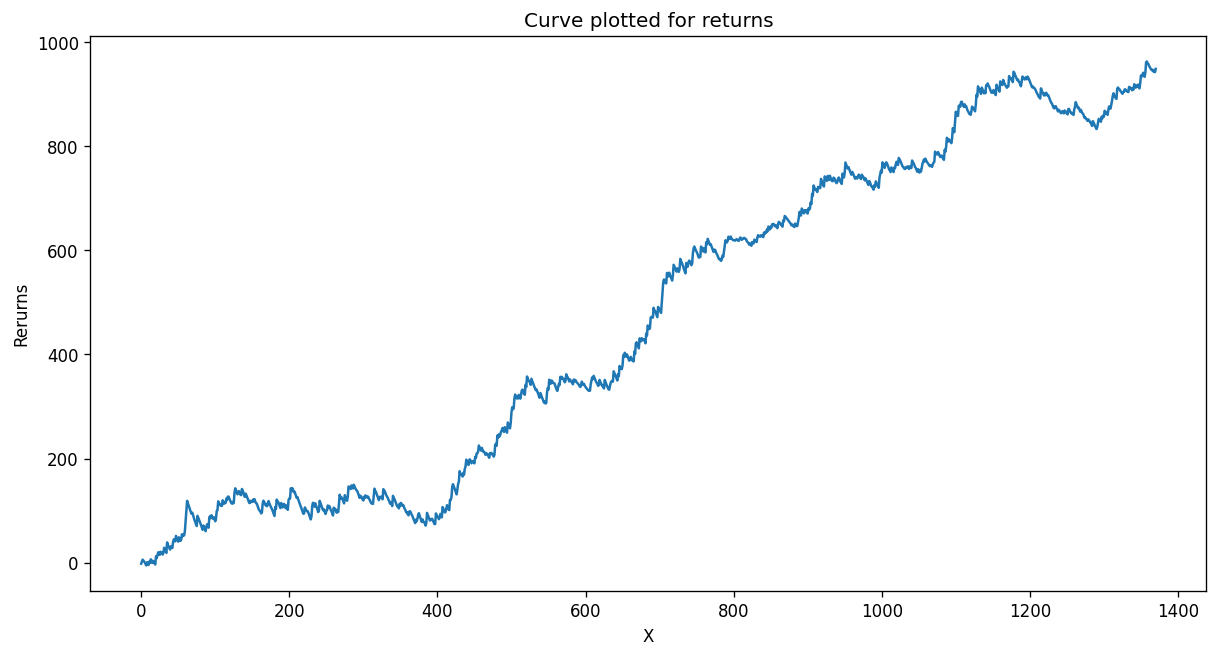

In [60]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [61]:
trades['PnL'].sum()

948.1726600000468

## Optimize params

In [62]:
# max_sl_params = [x / 10.0 for x in range(20, 60, 5)]
# trailing_sl_params = [x / 10.0 for x in range(20, 85, 5)]
# optimize_stats, heatmap = bt.optimize(max_sl=max_sl_params,
#                                       trailing_sl=trailing_sl_params,
#                                         maximize='Return [%]',
#                                         random_state=0,
#                                         return_heatmap=True)

In [63]:
# optimize_stats

In [64]:
# import seaborn as sns
# heatmap_df = heatmap.unstack()
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
# plt.show()